In [1]:
## Figure 14 - Phase Corrections in Time-series Domain shown in map/point view on Isabela island
%matplotlib inline
import os
from dateutil.relativedelta import relativedelta
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from pysar.simulation.plot import *
from pysar.utils import ptime, readfile, writefile, utils as ut, network as pnet, plot as pp
from pysar.objects import timeseries, sensor

work_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE')
os.chdir(work_dir)
print('Go to directory: '+work_dir)
proj_name = sensor.project_name2sensor_name(work_dir)[1]

pts_lat, pts_lon = -1.0352, -91.1917
mask_file = 'maskIsabela.h5'
ts_files = ['geo_timeseries.h5', 
            'ECMWF.h5', 
            'ramp.h5',
            'topoResid.h5',
            'geo_timeseries_ECMWF_ramp_demErr.h5']
labels = ['Raw phase',
          'Tropospheric delay',
          'Phase ramp',
          'Topographic residual',
          'Displacement']

obj = timeseries(ts_files[0])
obj.open(print_msg=False)
ref_lat, ref_lon = float(obj.metadata['REF_LAT']), float(obj.metadata['REF_LON'])
print('Done.')

Go to directory: /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE
Done.


save to file: /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE/phaseCorrection_map.png


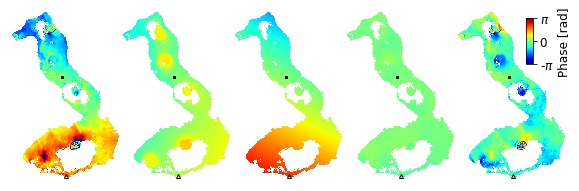

In [9]:
## Figure 14a - Map View

## prepare data
# date of interest
m_date = '20150927'
s_date = '20160512'
# area of interest
W, N, E, S = -91.60, 0.18, -90.78, -1.07
geo_box = (W, N, E, S)
coord = ut.coordinate(obj.metadata)
pix_box = coord.box_geo2pixel(geo_box)
# read data
wrap_range = [-1*np.pi, np.pi]
mask = readfile.read(mask_file, box=pix_box)[0]
pha = []
for fname in ts_files:
    data  = readfile.read(fname, datasetName=s_date, box=pix_box)[0]
    data -= readfile.read(fname, datasetName=m_date, box=pix_box)[0]
    data *= 100.
    data[mask==0] = np.nan
    data = ut.wrap(data, wrap_range=wrap_range)
    pha.append(data)

## plot
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=[10, 4], sharex=True, sharey=True)
for i in range(len(pha)):
    m = pp.BasemapExt(llcrnrlon=geo_box[0], llcrnrlat=geo_box[3],
                      urcrnrlon=geo_box[2], urcrnrlat=geo_box[1],
                      projection='cyl', resolution='i', area_thresh=1.,
                      suppress_ticks=False, ax=ax[i])
    im = m.imshow(pha[i], origin='upper', interpolation='nearest',
                  vmin=wrap_range[0], vmax=wrap_range[1], cmap='jet')
    ax[i].plot(ref_lon, ref_lat, 'ks', ms=2)              #reference point
    ax[i].plot(pts_lon, pts_lat, "k^", mfc='none', mew=1., ms=4)  #point of interest
    ax[i].get_xaxis().set_ticks([])
    ax[i].get_yaxis().set_ticks([])
    ax[i].axis('off')
fig.subplots_adjust(wspace=0.0)

# colorbar
cax = fig.add_axes([0.84, 0.61, 0.01, 0.16])
cbar = plt.colorbar(im, cax=cax, ticks=[wrap_range[0], 0, wrap_range[1]])
cbar.ax.set_yticklabels([r'-$\pi$', '0', r'$\pi$'])
cbar.ax.tick_params(which='both', direction='out', labelsize=font_size)
cbar.set_label('Phase [rad]', fontsize=font_size)

# output
out_file = os.path.join(work_dir, 'phaseCorrection_map.png')
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save to file: '+out_file)
plt.show()

save to file: /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE/phaseCorrection_point.png


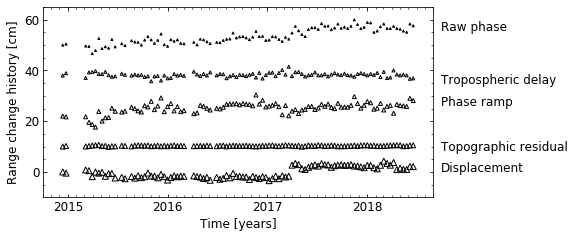

In [10]:
## Figure 14b - Point View

## time/space info
y, x = coord.geo2radar(pts_lat, pts_lon)[0:2]
box = (x, y, x+1, y+1)
dates = ptime.date_list2vector(obj.dateList)[0]

# plot
marker_size = 6
offset = [50, 38, 22, 10, 0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[7, 3.5])
ts_data = []
for i in range(len(ts_files)-1, -1, -1):
    # read point time-series data
    d_ts = np.squeeze(readfile.read(ts_files[i], box=box)[0]) * 100.
    d_ts -= d_ts[0]
    d_ts += offset[i]
    # plot
    ms = marker_size - 1 * (len(ts_files) - 1 - i)
    ax.scatter(dates, d_ts, marker='^', s=ms**2, label=labels[i], facecolors='none', edgecolors='k', linewidth=1.)
    ax.annotate(labels[i], xy=(1.02, d_ts[-1]-2), xycoords=ax.get_yaxis_transform(), color='k', fontsize=font_size)

# axis format
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax, t0, t1 = pp.auto_adjust_xaxis_date(ax, obj.yearList, fontsize=font_size)
ax.set_xlabel('Time [years]', fontsize=font_size)
ax.set_ylabel('Range change history [cm]', fontsize=font_size)
ax.set_ylim(-10, 65)
ax.set_xlim(t0+relativedelta(months=2), t1)
ax.yaxis.set_minor_locator(AutoMinorLocator())

out_file = os.path.join(work_dir, 'phaseCorrection_point.png')
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save to file: '+out_file)
plt.show()

In [11]:
## Backup - time-series map view for supp

ts_files = ['geo_timeseries.h5', 
            'geo_timeseries_ECMWF.h5', 
            'geo_timeseries_ECMWF_demErr.h5', 
            'geo_timeseries_ECMWF_demErr_ramp.h5']
suffix = ['ts_raw',
          'ts_raw_trop',
          'ts_raw_trop_topo',
          'ts_raw_trop_topo_ramp']
for i in range(len(ts_files)):
    cmd =  'view.py {} -m {} -o {}_{}.png '.format(ts_files[i], mask_file, proj_name, suffix[i])
    cmd += '--sub-lat {} {} --sub-lon {} {} '.format(S, N, W, E)
    cmd += '--wrap --wrap-range -10 10 '
    cmd += '--nomultilook --noaxis --notick --notitle --no-tight-layout '
    cmd += '--figsize 8 10 --fontsize 6 --dpi 600 --nodisplay '
    print(cmd)
    #os.system(cmd)

view.py geo_timeseries.h5 -m maskIsabela.h5 -o GalapagosSenDT128_ts_raw.png --sub-lat -1.07 0.18 --sub-lon -91.6 -90.78 --wrap --wrap-range -10 10 --nomultilook --noaxis --notick --notitle --no-tight-layout --figsize 8 10 --fontsize 6 --dpi 600 --nodisplay 
view.py geo_timeseries_ECMWF.h5 -m maskIsabela.h5 -o GalapagosSenDT128_ts_raw_trop.png --sub-lat -1.07 0.18 --sub-lon -91.6 -90.78 --wrap --wrap-range -10 10 --nomultilook --noaxis --notick --notitle --no-tight-layout --figsize 8 10 --fontsize 6 --dpi 600 --nodisplay 
view.py geo_timeseries_ECMWF_demErr.h5 -m maskIsabela.h5 -o GalapagosSenDT128_ts_raw_trop_topo.png --sub-lat -1.07 0.18 --sub-lon -91.6 -90.78 --wrap --wrap-range -10 10 --nomultilook --noaxis --notick --notitle --no-tight-layout --figsize 8 10 --fontsize 6 --dpi 600 --nodisplay 
view.py geo_timeseries_ECMWF_demErr_ramp.h5 -m maskIsabela.h5 -o GalapagosSenDT128_ts_raw_trop_topo_ramp.png --sub-lat -1.07 0.18 --sub-lon -91.6 -90.78 --wrap --wrap-range -10 10 --nomultiloo